In [1]:
# !pip installs torchmetrics

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import sys

In [3]:
# Get project root (2 levels up)
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))

# Add to sys.path
sys.path.append(project_root)

# Confirm it's now in sys.path
print("Project root added to sys.path:", project_root)



Project root added to sys.path: c:\Users\Yaknan\Documents\Academics\Rebekah's Thesis\code from Charles\lassa_fever_prediction_with_climate_data


In [4]:
from models.EpidemiologyModels import EpidemiologyOneOutput, EpidemiologyModelAllVariable
from utils.Utilities import create_dataset, mar_dataset

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
torch.manual_seed(0)
np.random.seed(0)
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader,  TensorDataset
import torch.optim as optim
from torch.nn import functional as F

import random
from patsy import dmatrices
import statsmodels.api as sm
import sklearn.metrics as metrics

import matplotlib.gridspec as gridspec

import joblib

import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

torch.manual_seed(0)
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)


In [6]:
import os
print(os.getcwd())

c:\Users\Yaknan\Documents\Academics\Rebekah's Thesis\code from Charles\lassa_fever_prediction_with_climate_data\models\lstm\LSTM_One_output_per_model


In [7]:
sys.path.append(os.path.abspath(".."))
# Read Excel file
excel_file = '../../../data/raw/weeklydata.xlsx'
df = pd.read_excel(excel_file, engine='openpyxl')

In [8]:
# View data and column headings
print("Excel Data:")
print(df.head())
print("\nColumn Headings:")
print(df.columns)

Excel Data:
    state  year             datetime  epiweek  cases  tempmaxw  tempminw  \
0  Bauchi  2018  2018-01-07 00:00:00        1    1.0      29.5      10.8   
1  Bauchi  2018  2018-01-14 00:00:00        2    0.0      27.6      10.8   
2  Bauchi  2018  2018-01-21 00:00:00        3    0.0      30.5      11.7   
3  Bauchi  2018  2018-01-28 00:00:00        4    0.0      28.5      13.1   
4  Bauchi  2018  2018-02-04 00:00:00        5    0.0      34.6      15.6   

   tempw  humidityw  precipw  precipcovw  
0   19.0       36.1      0.0         0.0  
1   19.3       28.1      0.0         0.0  
2   21.2       24.8      0.0         0.0  
3   20.4       30.9      0.0         0.0  
4   24.8       23.8      0.0         0.0  

Column Headings:
Index(['state', 'year', 'datetime', 'epiweek', 'cases', 'tempmaxw', 'tempminw',
       'tempw', 'humidityw', 'precipw', 'precipcovw'],
      dtype='object')


In [9]:
assert df.isnull().sum().sum() == 0

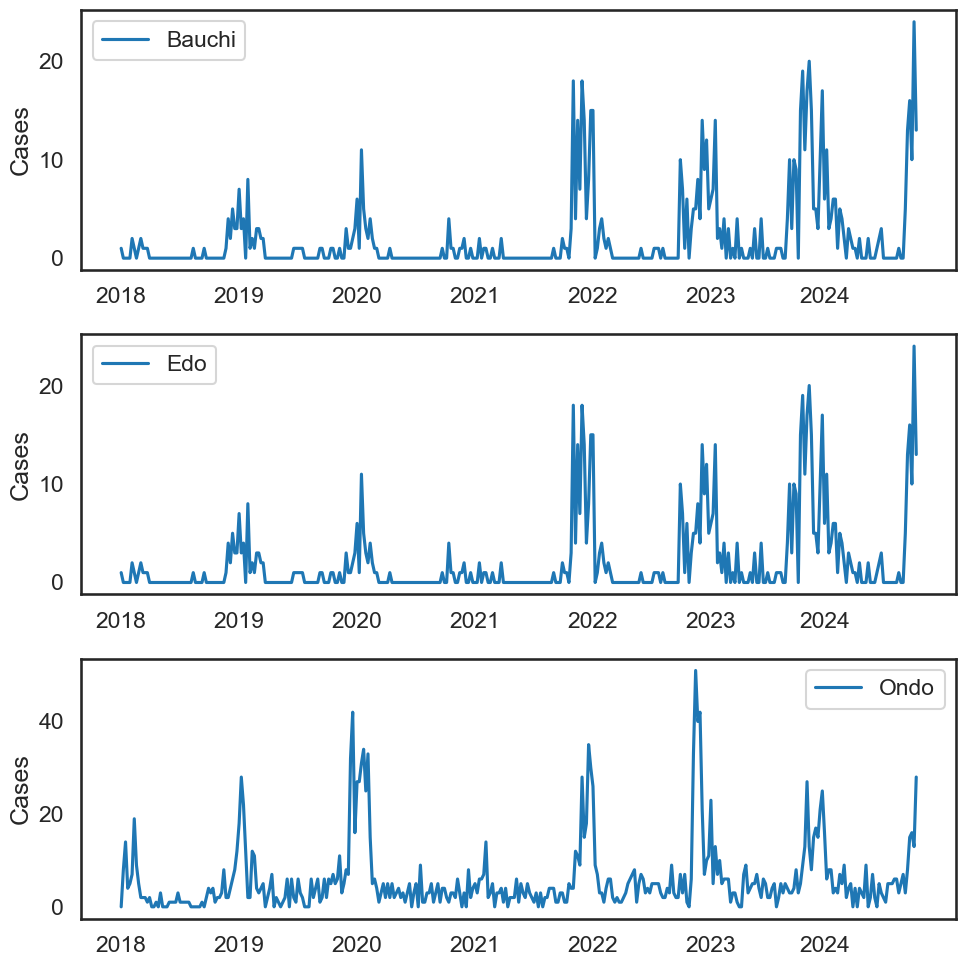

In [10]:
fig, axes = plt.subplots(3, 1, sharex=False, sharey=False, figsize=(10,10))
df.sort_values(['year', 'epiweek'], inplace=True)
state = df[df['state'] == 'Bauchi']['cases'].copy()

axes[0].plot(state.values, label='Bauchi')
axes[0].set_ylabel("Cases")
axes[0].set_xticks([0, 54, 108, 162, 216, 270,322], ['2018', '2019', '2020', '2021', '2022', '2023', '2024'])
axes[0].legend()


axes[1].plot(state.values, label='Edo')
axes[1].set_ylabel("Cases")
axes[1].set_xticks([0, 54, 108, 162, 216, 270,322], ['2018', '2019', '2020', '2021', '2022', '2023', '2024'])
axes[1].legend()


state = df[df['state'] == 'Ondo']['cases'].copy()
axes[2].plot(state.values, label='Ondo')
axes[2].set_ylabel("Cases")
axes[2].set_xticks([0, 54, 108, 162, 216, 270,322], ['2018', '2019', '2020', '2021', '2022', '2023', '2024'])
axes[2].legend()
fig.tight_layout()
fig.savefig("count_by_state.png", dpi=300, bbox_inches='tight')

In [11]:
## normalize dataset
x_features = ['tempmaxw', 'tempminw', 'tempw', 'humidityw', 'precipw', 'precipcovw']
target_feature = ['cases']
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

df[x_features] = feature_scaler.fit_transform(df[x_features].values)
df[target_feature] = target_scaler.fit_transform(df[target_feature].values)

df[x_features].head()

joblib.dump(feature_scaler, 'feature_scaler.bin', compress=True)
joblib.dump(target_scaler, 'target_scaler.bin', compress=True)

['target_scaler.bin']

In [12]:
def train(df, train_val_years, train_features, target_feature, lstm_hidden_size=100, n_lstm_layers=2,
          lookback = 6, n_epochs = 2000, bidirection=False, state_filter='Bauchi'):

    save_path = "./{}_model.pt".format(state_filter)
    best_value = torch.inf

    df = df[df['year'].isin(train_val_years)]    
    
    data = df[df['state']==state_filter].copy()
    data.sort_values(['year', 'epiweek'], inplace=True)
    data.sort_values(['year', 'epiweek'], inplace=True)

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = EpidemiologyOneOutput(feature_dim=len(train_features), output_dim = output_dim, hidden_size=lstm_hidden_size, num_lstm_layers=n_lstm_layers, device=device)
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.PoissonNLLLoss(log_input=False)

    data.index = data.datetime
    data.drop(columns=['state', 'year' ,'datetime', 'epiweek'], inplace=True)       

    X, Y = create_dataset(data, train_features, target_feature, lookback)
    X, Y = X.to(device), Y.to(device)

    train_len = int(X.shape[0]*0.80)
    X_train, Y_train, X_val, Y_val = X[:train_len], Y[:train_len], X[train_len:], Y[train_len:] 
    
    
    loader = DataLoader(TensorDataset(X_train, Y_train), shuffle=False, batch_size=32)
    best_model = None
    
    train_log = []
    val_log = []
    print("Training Model for {} ....".format(state_filter))
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for X_batch, Y_batch in loader:
            Y_pred = model(X_batch)
            diff = Y_pred[:, 1:] - Y_pred[:, :-1]
            loss = 0.7*loss_fn(Y_pred, Y_batch) + 0.3*torch.mean(diff ** 2)            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss +=loss.item()            
        train_loss = train_loss/len(loader)
        train_log.append(train_loss)
        with torch.no_grad():
            model.eval()
            Y_pred_val = model(X_val)
            val_loss = loss_fn(Y_pred_val, Y_val).cpu().item()
            val_log.append(val_loss)

            if (epoch+1) % 10 == 0:
                print("Epoch %d: train MSE and Poisson %.4f, val Poisson Loss %.4f" % (epoch, train_loss, val_loss))
                

    print("Training Model for {a} completed with Test Poisson Loss {b:.2f}".format(a=state_filter, b=val_loss))
    fig= plt.figure(figsize=(20,10))
    plt.plot(np.array(train_log), c ='red', label="Train")
    plt.plot(np.array(val_log), c ='green', label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Poisson Loss (On 0-1 Scaled Data)")
    plt.legend()

    plt.title('Training and Test Performance for {a} state.\n Test MSE + Poisson Loss (On 0-1 Scaled Data) {b:.3f}'.format(a=state_filter, b=val_loss), fontsize=20)
    plt.tight_layout()
    plt.savefig('{}_train_viz.png'.format(state_filter), bbox_inches='tight')
    torch.save(model, save_path)

    return model

In [13]:
# Define the years for training and testing data
train_val_years = [2019, 2020, 2022, 2023]  # Years for training data
test_years = [2018, 2019, 2020, 2022, 2023, 2024]  # test behavior of all years including 2023

#training features including past cases
train_features = ['tempmaxw', 'tempminw', 'tempw', 'humidityw', 'precipw', 'precipcovw', 'cases']
target_feature = ['cases']

lookback = 12
output_dim = 1

In [20]:
import sys, os

# Get the path to the models/ directory
models_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))

# Add it to sys.path if not already there
if models_path not in sys.path:
    sys.path.append(models_path)
print(models_path)

c:\Users\Yaknan\Documents\Academics\Rebekah's Thesis\code from Charles\lassa_fever_prediction_with_climate_data\models


In [ ]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

from ipywidgets import interact_manual
@interact_manual(retrain_model = [False, True], state=["Bauchi", "Edo", "Ondo"], lookback = [4, 8,12, 1], lstm_hidden_size=[30, 40, 60]
                 , n_lstm_layers=[3, 2, 4, 1], bidirection_lstm=[False, True]
                 , n_epochs = [10, 1000, 1500, 2000])
def train_visualization(retrain_model,n_epochs, state, lookback, lstm_hidden_size, n_lstm_layers
                  ,bidirection_lstm, ):
    save_path = "./{}_model.pt".format(state)
    
    state_filter = state
    data=df
    if retrain_model:
        model = train(df, train_val_years, train_features, target_feature, lstm_hidden_size=lstm_hidden_size, n_lstm_layers=n_lstm_layers, lookback = lookback,
                           n_epochs = n_epochs, bidirection=False, state_filter=state_filter)
    else:
        model = torch.load(save_path, weights_only=False)

    mse = metrics.mean_squared_error
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    data = df[df['state']==state_filter]
    data = data[data['year'].isin(test_years)].copy()
    data.sort_values(['year', 'epiweek'], inplace=True)
    data.sort_values(['year', 'epiweek'], inplace=True)   
    
    test_gp = data.groupby(['state'])
    s = state_filter
    state_data = test_gp.get_group(s)
    fig, axs = plt.subplots(2, 3, figsize=(20,10))
    for j, ys in enumerate(test_years):
        state_data_year = state_data[state_data['year']== ys]
        state_data_year.drop(columns=['state', 'year', 'datetime'], inplace=True)
        X_test, y_test = create_dataset(state_data_year, train_features, target_feature, lookback)

        X_test, y_test = X_test.to(device), y_test.to(device)

        with torch.no_grad():
            model.eval()
            rl = - 21
            X_test = torch.roll(X_test, rl, 0)
            y_test = torch.roll(y_test, rl, 0)

            y_pred = model(X_test)            
            y_pred_transformed = target_scaler.inverse_transform(y_pred.cpu().numpy()[:, -1])
            y_test_transformed = target_scaler.inverse_transform(y_test.cpu().numpy()[:, -1])
            err= mse(y_pred_transformed[:, -1], y_test_transformed[:, -1])

        # plot
        axs[j//3, j%3].title.set_text(str(ys)+", MSE: %.3F"%(err))
        axs[j//3, j%3].plot(y_pred_transformed, label='pred_y')
        axs[j//3, j%3].plot(y_test_transformed, label='true_y')
        axs[j//3, j%3].legend(loc="upper right")
        axs[j//3, j%3].set_xticks([0, 12, 24, 37, 52], ['June', 'Sep', 'Dec', 'Mar', 'June'])
        axs[j//3, j%3].set_ylabel('Number of cases')
        
    fig.suptitle('Predictions for {} state'.format(s), fontsize=20)
    fig.tight_layout()
    fig.savefig('{}_predictions.png'.format(state), bbox_inches='tight')    

interactive(children=(Dropdown(description='retrain_model', options=(False, True), value=False), Dropdown(desc…

In [16]:
from ipywidgets import interact
import shap

class ModelWrapperLSTMOneOutput(nn.Module):
    def __init__(self, theModel, feature_transform):
        super().__init__()
        self.model = theModel
        self.feature_transform =feature_transform 
    def forward(self, X):
        n1 = X.shape[0]
        X = torch.stack([torch.from_numpy(X[i-4:i]).float() for i in range(4, X.shape[0])])
        for i in range(n1 - X.shape[0]):
            X = torch.concat((X[[i]], X))
        Pred = self.model(X)[:,-1, :]
        Pred = target_scaler.inverse_transform(Pred.detach().numpy())
        return Pred[:, -1]

In [ ]:
@interact_manual(state=["Bauchi", "Edo", "Ondo"], year = [2018, 2019, 2020, 2021, 2022, 2023], lookback = [4, 8, 1], Num_Instances = [200, 400, 600, 800, 1200])
def explain_by_permutation(state, year, Num_Instances):
    data = df[df['state']==state].copy()
    test_data = data[data['year'].isin([year])].copy()
    test_data.sort_values(['year', 'epiweek'], inplace=True)    
    test_data = test_data.reset_index()
    test_data.drop(columns=['state', 'year', 'datetime', 'index', 'epiweek'], inplace=True)
    
    save_path = "./{}_model.pt".format(state)
    model = torch.load(save_path, weights_only=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load(save_path, weights_only=False)
    model = model.to(device)
    
    model = ModelWrapperLSTMOneOutput(model, train_features)
    
    def custom_masker(mask, x):
        # in this simple example we just zero out the features we are masking
        d =(x*mask).reshape(1, len(x)) 
        return d
    
    explainer = shap.PermutationExplainer(model, custom_masker)    
    shap_values = explainer(test_data[train_features][:Num_Instances])
    fig = plt.figure(figsize=(20,15))
    plt.subplot(211, frameon=True)
    shap.plots.violin(shap_values,show=False)
    plt.subplot(212, frameon=True)
    shap.plots.bar(shap_values, order=shap_values.abs.mean(0),  show=False)
    plt.subplots_adjust(bottom=0.1, right=1.2, top=1.5)
    plt.show()

interactive(children=(Dropdown(description='state', options=('Bauchi', 'Edo', 'Ondo'), value='Bauchi'), Dropdo…